ConvLSTM trained on gridded forcings for all stations

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
from sklearn import preprocessing
import netCDF4 as nc
import torch
from torch import nn, utils
from torch.utils.tensorboard import SummaryWriter
from src import load_data, evaluate, conv_lstm, datasets
import torch.autograd as autograd
import pickle

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190722-132357'

In [2]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='../log.out', mode='a')
chandler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('%(asctime)s - {} - %(message)s'.format(time_stamp))
fhandler.setFormatter(formatter)
chandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.addHandler(chandler)
logger.setLevel(logging.INFO)

In [3]:
USE_CUDA = False
if torch.cuda.is_available():
    print('CUDA Available')
    USE_CUDA = True
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
num_devices = torch.cuda.device_count() if USE_CUDA else 0
logger.warning('cuda devices: {}'.format(list(torch.cuda.get_device_name(i) for i in range(num_devices))))
torch.manual_seed(0)
np.random.seed(0)

2019-07-22 13:23:57,664 - 20190722-132357 - cuda devices: []


In [4]:
seq_len = 50
seq_steps = 1

train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(hours=seq_len * seq_steps)  # first day for which to make a prediction in train set
train_end = '2012-09-30'
val_start = '2012-10-01'
val_end = '2012-12-31'
test_start = '2013-01-01'
test_end = '2014-12-31'

In [5]:
rdrs_vars = [4,5]
train_dataset = datasets.RdrsDataset(rdrs_vars, seq_len, seq_steps, train_start, train_end)
val_dataset = datasets.RdrsDataset(rdrs_vars, seq_len, seq_steps, val_start, val_end,
                                   conv_scalers=train_dataset.conv_scalers, fc_scalers=train_dataset.fc_scalers)
test_dataset = datasets.RdrsDataset(rdrs_vars, seq_len, seq_steps, test_start, test_end, 
                                    conv_scalers=train_dataset.conv_scalers, fc_scalers=train_dataset.fc_scalers)

In [9]:
# Train model
num_epochs = 100
learning_rate = 3e-3
patience = 40
min_improvement = 1.0
best_loss_model = (-1, np.inf, None)

# Prepare model
stateful_lstm = False
lstm_layers = 2
conv_hidden_dims = [4] * (lstm_layers - 1) + [4]
H_fc = 4
batch_size = 20
fc_layers = 1
kernel_size = (3,3)
dropout = 0.2
pooling = [False, True]# * lstm_layers
fc_activation = nn.LeakyReLU
model = conv_lstm.ConvLSTMLSTMRegression((train_dataset.conv_height, train_dataset.conv_width), train_dataset.n_fc_vars, train_dataset.n_conv_vars, conv_hidden_dims, 
                                     kernel_size, lstm_layers, dropout, fc_layers, H_fc, pooling).to(device)
model = torch.nn.DataParallel(model, device_ids=list(range(num_devices)))
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter()
param_description = {'time_stamp': time_stamp, 'H_conv': conv_hidden_dims, 'H_fc': H_fc, 'batch_size': batch_size, 'lstm_layers': lstm_layers, 'fc_layers': fc_layers, 'kernel_size': kernel_size, 'loss': loss_fn, 
                     'optimizer': optimizer, 'lr': learning_rate, 'patience': patience, 'min_improvement': min_improvement, 'pooling': pooling, 'stateful_lstm': stateful_lstm, 'fc_activation': fc_activation,
                     'num_epochs': num_epochs, 'seq_len': seq_len, 'seq_steps': seq_steps, 'dropout': dropout, 'train_start': train_start, 'train_end': train_end, 'val_start': val_start, 
                     'val_end': val_end, 'test_start': test_start, 'test_end': test_end, 'n_conv_vars': train_dataset.n_conv_vars, 'n_fc_vars': train_dataset.n_fc_vars, 'model': str(model).replace('\n','').replace(' ', ''),
                     'train len':len(train_dataset), 'val len': len(val_dataset), 'conv_height': train_dataset.conv_height, 'conv_width': train_dataset.conv_width, 'test len': len(test_dataset)}
writer.add_text('Parameter Description', str(param_description))

In [10]:
if stateful_lstm:
    train_sampler = datasets.StatefulBatchSampler(train_dataset, batch_size)
    val_sampler = datasets.StatefulBatchSampler(val_dataset, batch_size)
    test_sampler = datasets.StatefulBatchSampler(test_dataset, batch_size)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler, pin_memory=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_sampler=val_sampler, pin_memory=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler, pin_memory=True)
else:
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True)

In [13]:
for epoch in range(num_epochs):
    model.train()

    epoch_losses = torch.tensor(0.0)
    conv_hidden_states = None
    lstm_hidden_states = None
    for i, train_batch in enumerate(train_dataloader):
        y_train = train_batch['y'].reshape((-1, 1)).to(device, non_blocking=True)
        if not stateful_lstm:
            conv_hidden_states = None
            lstm_hidden_states = None
        
        y_pred, conv_hidden_states, lstm_hidden_states = model(train_batch['x_conv'], train_batch['x_fc'], conv_hidden_states=conv_hidden_states, lstm_hidden_states=lstm_hidden_states)
        loss = loss_fn(y_pred, y_train)
        epoch_losses += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = (epoch_losses / len(train_dataloader)).item()
    print('Epoch', epoch, 'mean train loss:\t{}'.format(epoch_loss))
    writer.add_scalar('loss', epoch_loss, epoch)
    
    # eval on validation split
    model.eval()
    val_losses = torch.tensor(0.0)
    for i, val_batch in enumerate(val_dataloader):
        y_val = val_batch['y'].reshape((-1,1)).to(device, non_blocking=True)
        if not stateful_lstm:
            conv_hidden_states = None
            lstm_hidden_states = None
        
        batch_pred, conv_hidden_states, lstm_hidden_states = model(val_batch['x_conv'], val_batch['x_fc'], conv_hidden_states=conv_hidden_states, lstm_hidden_states=lstm_hidden_states)
        val_losses += loss_fn(batch_pred.detach(), y_val).detach()
        
    val_mse = (val_losses / len(val_dataloader)).item()
    print('Epoch {} mean val mse:    \t{}'.format(epoch, val_mse))
    writer.add_scalar('loss_eval', val_mse, epoch)

    if val_mse < best_loss_model[1] - min_improvement:
        best_loss_model = (epoch, val_mse, model.state_dict())  # new best model
        load_data.pickle_model('ConvLSTM+LinearLayer_VIC', model, 'allStations', time_stamp)
    elif epoch > best_loss_model[0] + patience:
        print('Patience exhausted in epoch {}. Best val-loss was {}'.format(epoch, best_loss_model[1]))
        break

print('Using best model from epoch', str(best_loss_model[0]), 'which had loss', str(best_loss_model[1]))
model.load_state_dict(best_loss_model[2])
load_data.pickle_model('ConvLSTM+LinearLayer_VIC', model, 'allStations', time_stamp)

Epoch 0 mean train loss:	41.48896026611328
Epoch 0 mean val mse:    	1.5045281648635864
Saved model as ../pickle/models/ConvLSTM+LinearLayer_VIC_allStations_20190722-132357.pkl
Epoch 1 mean train loss:	3.8314461708068848
Epoch 1 mean val mse:    	1.47687828540802
Using best model from epoch 0 which had loss 1.5045281648635864
Saved model as ../pickle/models/ConvLSTM+LinearLayer_VIC_allStations_20190722-132357.pkl


In [15]:
logger.warning('predicting')
model.eval()

predict = test_dataset.data_runoff.copy()
predict['runoff'] = np.nan
pred_array = []
for i, test_batch in enumerate(test_dataloader):
    if not stateful_lstm:
        conv_hidden_states = None
        lstm_hidden_states = None        
    pred, conv_hidden_states, lstm_hidden_states = model(test_batch['x_conv'], test_batch['x_fc'], conv_hidden_states=conv_hidden_states, lstm_hidden_states=lstm_hidden_states)
    pred_array.append(pred.detach().reshape(-1))
    
pred_array = torch.cat(pred_array).cpu()

if stateful_lstm:
    # reorder time series
    pred_indices = np.array(list(test_sampler.__iter__())).reshape(-1)
    pred_array = pred_array[pred_indices.argsort()]

if len(pred_array) != len(predict):
    print('Warning: length of prediction {} and actuals {} does not match. Ignoring excess actuals.'.format(len(pred_array), len(predict)))
    predict = predict.iloc[:len(pred_array)]
    
predict['runoff'] = pred_array

2019-07-22 13:29:13,238 - 20190722-132357 - predicting


02GA010 	NSE: -0.3634410965832793 	MSE: 1117.4482419351757 (clipped to 0)
Median NSE (clipped to 0) -0.3634410965832793 / Min -0.3634410965832793 / Max -0.3634410965832793
Median MSE (clipped to 0) 1117.4482419351757 / Min 1117.4482419351757 / Max 1117.4482419351757


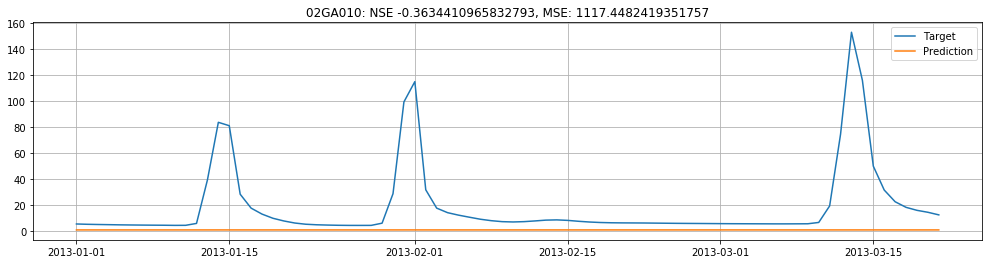

In [17]:
actuals = test_dataset.data_runoff.copy()
if len(actuals) != len(predict):
    print('Warning: length of prediction {} and actuals {} does not match. Ignoring excess actuals.'.format(len(predict), len(actuals)))
    actuals = actuals[:len(predict)]

nse_list = []
mse_list = []
for station in predict['station'].unique():
    pred = predict[predict['station'] == station].set_index('date')['runoff']
    act = actuals[actuals['station'] == station].set_index('date')['runoff']
    nse, mse = evaluate.evaluate_daily(station, pred, act, plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))
writer.add_scalar('nse_median', np.median(nse_list))

In [ ]:
writer.close()

In [ ]:
save_df = pd.merge(predict.rename({'runoff': 'prediction'}, axis=1), actuals.rename({'runoff': 'actual'}, axis=1), 
                   on=['date', 'station'])[['date', 'station', 'prediction', 'actual']]
load_data.pickle_results('ConvLSTM+LinearLayer_VIC', save_df, time_stamp)

In [ ]:
datetime.now().strftime('%Y%m%d-%H%M%S')